In [1]:
import sys;
sys.path.insert(0, '..')

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Experiments on Quantum Hardware

In this notebook, we will run a couple of example circuits from the book on real quantum hardware. If you would like to run experiments yourself, you can follow the instructions to set up an IBM Quantum account and replace the token with your own.

To re-run the code in this notebook you will need to:

* Sign up for an IBM Quantum Platform Open Plan [here](https://docs.quantum.ibm.com/start/setup-channel) and get a token
* Install Qiskit Runtime [`qiskit-ibm-runtime`](https://docs.quantum.ibm.com/start/install) (this notebook uses the Sampler primitive)

In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
from qiskit.compiler import transpile
from qiskit.visualization import plot_histogram

Insert your IBM Quantum API key and authenticate to the service. Note, that this uses for the default instance for Open Plan users. If you are using a a different plan (i.e., pay-as-you-go) you can change your instance using the `instance` parameter ([documentation](https://docs.quantum.ibm.com/run/instances#connect-instance)).

In [7]:
QiskitRuntimeService.save_account(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>", instance = "ibm-q/open/main", overwrite=True)

In [8]:
service = QiskitRuntimeService()

View the available backends:

In [9]:
service.backends()

[<IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_kyoto')>,
 <IBMBackend('ibm_osaka')>,
 <IBMBackend('ibm_sherbrooke')>]

### Step 1: Build circuit using Hume

We can import the `QuantumRegister` and `QuantumCircuit` classes from Hume. The example circuit is from chapter 4 (section 4.5.2).

In [10]:
from hume.simulator.circuit import QuantumRegister, QuantumCircuit

In [11]:
q = QuantumRegister(3)
qc = QuantumCircuit(q)

qc.h(q[0])
qc.h(q[1])
qc.mcx([q[0], q[1]], q[2])

### Step 2: Convert to Qiskit circuit instance using Hume's Qiskit utilities

Next, we use Hume's Qiskit utility function `hume_to_qiskit` to the Hume circuit instance to a Qiskit circuit instance.

In [12]:
from hume.qiskit.util import hume_to_qiskit

In [13]:
qc_qiskit = hume_to_qiskit(qc.regs, qc.transformations)

We must add measurement to the circuit:

In [14]:
qc_qiskit.measure_all()

In [15]:
qc_qiskit.draw()

┌───┐      ░ ┌─┐      
   q_0: ┤ H ├──■───░─┤M├──────
        ├───┤  │   ░ └╥┘┌─┐   
   q_1: ┤ H ├──■───░──╫─┤M├───
        └───┘┌─┴─┐ ░  ║ └╥┘┌─┐
   q_2: ─────┤ X ├─░──╫──╫─┤M├
             └───┘ ░  ║  ║ └╥┘
meas: 3/══════════════╩══╩══╩═
                      0  1  2

### Step 3: Choose a backend, transpile circuit, submit job

Let's start with the least busy available backend:

In [16]:
backend = service.least_busy(operational=True, simulator=False)
print(backend.name)

ibm_sherbrooke


In [17]:
sampler = Sampler(backend=backend)

Next, we do a basic transpilation (no optimization):

In [18]:
qc_transpiled = transpile(qc_qiskit, backend)

Submit a job to the chosen backend (with 1000 shots):

In [31]:
job = sampler.run(qc_transpiled, shots = 1000)

In [32]:
try:
    job_status = job.status()
    print(job_status)
except JobError as ex:
    print("Something wrong happened!: {}".format(ex))

JobStatus.QUEUED


### Look at the results

In [38]:
result = job.result()

In [43]:
# Get the counts of the outcomes (for each shot)
quasi_probs = result.quasi_dists

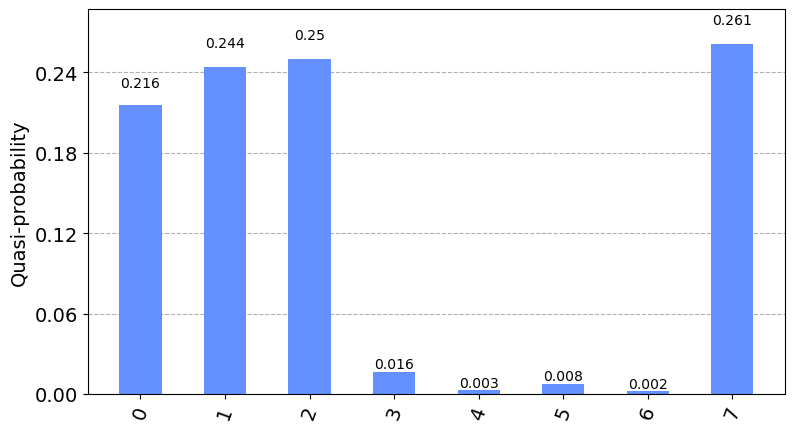

In [44]:
plot_histogram(quasi_probs, figsize=(9,5))